In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Oct 13 12:17:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import time
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import numpy as np

BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_CLASSES = 20
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("✅ Using device:", DEVICE)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


✅ Using device: cuda
GPU: Tesla T4


In [ ]:
drive_base = "/content/drive/MyDrive/movie_genre_project"
split_dir_drive = os.path.join(drive_base, "splits")
posters_drive = os.path.join(drive_base, "data/posters")

local_base = "/content/movie_genre_project"
os.makedirs(local_base, exist_ok=True)

# Copy splits and poster folder
!cp -r "{drive_base}/data" "{local_base}/"
!cp -r "{drive_base}/splits" "{local_base}/"

split_dir = os.path.join(local_base, "splits")
posters_local = os.path.join(local_base, "posters")

train_csv = "/content/movie_genre_project/splits/train_dataset.csv"
val_csv = "/content/movie_genre_project/splits/val_dataset.csv"

for csv_path in [train_csv, val_csv]:
    df = pd.read_csv(csv_path)
    df['poster_path'] = df['poster_path'].str.replace(
        '/content/drive/MyDrive/movie_genre_project/data/posters',
        '/content/movie_genre_project/data/posters',
        regex=False
    )
    df.to_csv(csv_path, index=False)
    print(f"✅ Updated paths in {csv_path}")

✅ Updated paths in /content/movie_genre_project/splits/train_dataset.csv
✅ Updated paths in /content/movie_genre_project/splits/val_dataset.csv


In [ ]:
from pathlib import Path

class MoviePosterDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

        # Filter out missing images right here:
        self.df = self.df[self.df['poster_path'].apply(os.path.exists)]
        self.df = self.df.reset_index(drop=True)
        print(f"✅ Dataset loaded with {len(self.df)} valid images")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['poster_path']
        label = int(row['genre_idx'])

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception:
            print(f"⚠️ Skipping broken image: {img_path}")
            # pick next valid sample
            return self.__getitem__((idx + 1) % len(self.df))

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)


# -----------------------------
# TRANSFORMS
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# -----------------------------
# LOADERS
# -----------------------------
train_dataset = MoviePosterDataset(train_csv, transform=train_transform)
val_dataset = MoviePosterDataset(val_csv, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True)

print(f"✅ Loaded {len(train_dataset)} training images and {len(val_dataset)} validation images")

# -----------------------------
# MODEL
# -----------------------------
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


✅ Dataset loaded with 5559 valid images
✅ Dataset loaded with 699 valid images
✅ Loaded 5559 training images and 699 validation images


In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()

In [ ]:
def validate(model, dataloader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating", leave=False):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()

Sample path: /content/movie_genre_project/data/posters/Double_Dragon.jpg
Exists: True


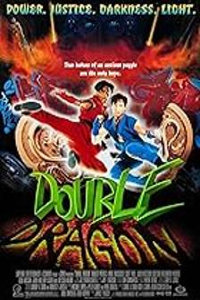

In [ ]:


sample_path = pd.read_csv(train_csv).iloc[0]['poster_path']
print("Sample path:", sample_path)
print("Exists:", os.path.exists(sample_path))

if os.path.exists(sample_path):
    display(Image.open(sample_path).resize((200,300)))


In [ ]:
best_val_acc = 0.0
best_model_path = os.path.join(drive_base, "best_resnet34_movie_genre.pth")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    duration = time.time() - start_time
    print(f"\n📅 Epoch {epoch+1}/{NUM_EPOCHS} ({duration/60:.2f} min)")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    # 🔥 Save best model automatically
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ New best model saved with val_acc = {best_val_acc:.4f}")

print(f"\nTraining complete. Best validation accuracy: {best_val_acc:.4f}")
print(f"Best model saved at: {best_model_path}")


📅 Epoch 1/10 (0.75 min)
Train Loss: 1.8510 | Acc: 0.3949
Val   Loss: 1.6312 | Acc: 0.4478
✅ New best model saved with val_acc = 0.4478



📅 Epoch 2/10 (0.73 min)
Train Loss: 1.4330 | Acc: 0.5127
Val   Loss: 1.6831 | Acc: 0.4278



📅 Epoch 3/10 (0.73 min)
Train Loss: 1.1442 | Acc: 0.6183
Val   Loss: 1.8363 | Acc: 0.4120



📅 Epoch 4/10 (0.74 min)
Train Loss: 0.8965 | Acc: 0.7019
Val   Loss: 2.0142 | Acc: 0.3977



📅 Epoch 5/10 (0.73 min)
Train Loss: 0.6428 | Acc: 0.7985
Val   Loss: 2.1230 | Acc: 0.3906



📅 Epoch 6/10 (0.76 min)
Train Loss: 0.4516 | Acc: 0.8591
Val   Loss: 2.1904 | Acc: 0.4335



📅 Epoch 7/10 (0.73 min)
Train Loss: 0.3562 | Acc: 0.8908
Val   Loss: 2.4604 | Acc: 0.4077



📅 Epoch 8/10 (0.72 min)
Train Loss: 0.2887 | Acc: 0.9129
Val   Loss: 2.4916 | Acc: 0.4192



📅 Epoch 9/10 (0.73 min)
Train Loss: 0.2659 | Acc: 0.9235
Val   Loss: 2.6124 | Acc: 0.4106



📅 Epoch 10/10 (0.73 min)
Train Loss: 0.2124 | Acc: 0.9385
Val   Loss: 2.7903 | Acc: 0.4192

Training complete. Best validation accuracy: 0.4478
Best model saved at: /content/drive/MyDrive/movie_genre_project/best_resnet34_movie_genre.pth
